![header1](../fidle/img/00-Fidle-header-01.png)

# Logistic regression, in pure tensorflow
Logistic Regression with Mini-Batch Gradient Descent using pure TensorFlow.  
Note: This notebook use tensoflow 2 in compatibility mode 1.  
A good reason to use Keras ;-)

## Objectives :
A logistic regression has the objective of providing a probability of belonging to a class.  
X contains characteristics  
y contains the probability of membership (1 or 0)  

## Principe :
We'll look for a value of $\theta$ such that the linear regression $\theta^{T}X$ can be used to calculate our probability:  

$\hat{p} = h_\theta(X) = \sigma(\theta^T{X})$  

Where $\sigma$ is the logit function, typically a sigmoid (S) function:  

$
\sigma(t) = \dfrac{1}{1 + \exp(-t)}
$  

The predicted value $\hat{y}$ will then be calculated as follows:

$
\hat{y} =
\begin{cases}
  0 & \text{if } \hat{p} < 0.5 \\
  1 & \text{if } \hat{p} \geq 0.5
\end{cases}
$

**Calculation of the cost of the regression:**  
For a training observation x, the cost can be calculated as follows:  

$
c(\theta) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1 \\
  -\log(1 - \hat{p}) & \text{if } y = 0
\end{cases}
$

The regression cost function (log loss) over the whole training set can be written as follows:  

$
J(\theta) = -\dfrac{1}{m} \sum_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$
## Step 1 - Import and init

In [2]:
import numpy as np
import sklearn as sl
from sklearn import metrics

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib
import matplotlib.pyplot as plt
import math
import random
import os
import sys

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.2.9
Run time             : Tuesday 18 February 2020, 18:55:04
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf


### 1.1 - Usefull stuff

In [3]:
def vector_infos(name,V):
    '''Displaying some information about a vector'''
    with np.printoptions(precision=4, suppress=True):
        print("{:16} : ndim={}  shape={:10}  Mean = {}  Std = {}".format( name,V.ndim, str(V.shape), V.mean(axis=0), V.std(axis=0)))

def random_batch(X_train, y_train, batch_size):
    '''Returning a data set for a batch'''
    indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

### 1.2 - Parameters

In [4]:
data_size      = 1000       # Number of observations
data_cols      = 2          # observation size
data_noise     = 0.2
test_ratio     = 0.2        # Ratio of data reserved for validation
random_seed    = 123

learning_rate  = 0.01
n_epochs       = 1000
batch_size     = 50

epsilon        = 1e-7       # To avoid overflows on some calculations (log())

learning_rate2 = 0.01       # Pour la version 2
n_epochs2      = 6000
batch_size2    = 50


## Step 2 - Data preparation
### 2.1 - Get some data
Here the data is retrieved from sklearn's `make_moons' test set generator.

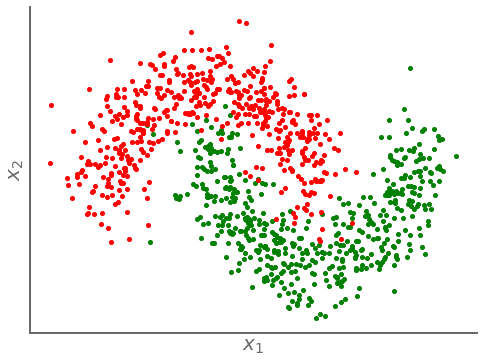

X_moons          : ndim=2  shape=(1000, 2)   Mean = [0.5008 0.252 ]  Std = [0.883  0.5359]
y_moons          : ndim=1  shape=(1000,)     Mean = 0.5  Std = 0.5


In [5]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(data_size, noise=data_noise, random_state=random_seed)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8,6)
ax.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', markersize=4, label="y=1 (positive)")
ax.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'ro', markersize=4, label="y=0 (negative)")
# ax.set_title("Données brutes")
# ax.legend()
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

vector_infos('X_moons',X_moons)
vector_infos('y_moons',y_moons)

### 2.2 - Preparation of data

We're going to:
- normalize the data
- add a column of 1 for bias
- Transform y_moons into a vector
- split the data to have : :
  - a training set
  - a test set

In [6]:
# ----- Normalization

scaler = sl.preprocessing.StandardScaler()
X_scaled   = scaler.fit_transform(X_moons)

# ----- Add column of 1

X_scaled_1 = np.c_[np.ones((data_size, 1)), X_scaled]

# ----- Reshape y_moon

y_moons_v = y_moons.reshape(-1,1)

# ----- Dataset -> train, test

test_size = int(data_size * test_ratio)
X_train = X_scaled_1[:-test_size]
X_test  = X_scaled_1[-test_size:]
y_train = y_moons_v[:-test_size]
y_test  = y_moons_v[-test_size:]

vector_infos('X_scaled',X_scaled)
vector_infos('X_scaled_1',X_scaled_1)
vector_infos('X_train',X_train)
vector_infos('y_train',y_train)
vector_infos('X_test',X_test)
vector_infos('y_test',y_test)

y_train_h = y_train.reshape(-1,) # for matplotlib visualization

X_scaled         : ndim=2  shape=(1000, 2)   Mean = [ 0. -0.]  Std = [1. 1.]
X_scaled_1       : ndim=2  shape=(1000, 3)   Mean = [ 1.  0. -0.]  Std = [0. 1. 1.]
X_train          : ndim=2  shape=(800, 3)    Mean = [ 1.      0.0206 -0.0056]  Std = [0.     0.9867 1.008 ]
y_train          : ndim=2  shape=(800, 1)    Mean = [0.5162]  Std = [0.4997]
X_test           : ndim=2  shape=(200, 3)    Mean = [ 1.     -0.0825  0.0225]  Std = [0.     1.0476 0.9672]
y_test           : ndim=2  shape=(200, 1)    Mean = [0.435]  Std = [0.4958]


### 2.3 - Have a look

#### Train data :

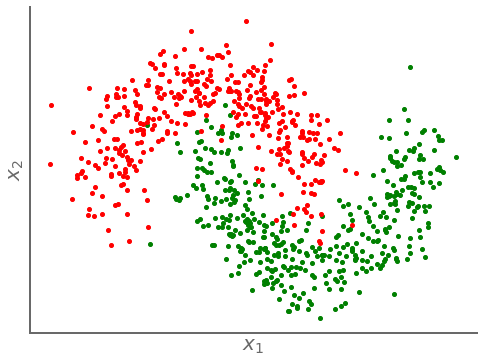

#### Test data :

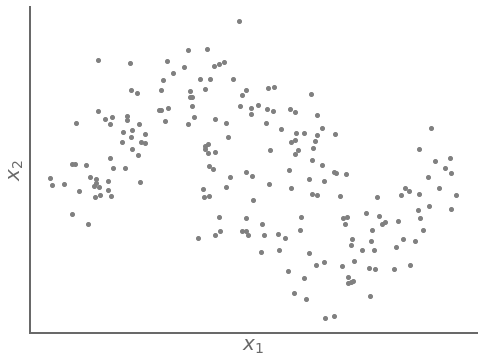

In [7]:
ooo.display_md("#### Train data :")
fig, axs = plt.subplots()
fig.set_size_inches(8,6)
axs.plot(X_train[y_train_h == 1, 1], X_train[y_train_h == 1, 2], 'o', color='green', markersize=4, label="Train / Positifs")
axs.plot(X_train[y_train_h == 0, 1], X_train[y_train_h == 0, 2], 'o', color='red',   markersize=4, label="Train / Négatifs")
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

ooo.display_md("#### Test data :")
fig, axs = plt.subplots()
fig.set_size_inches(8,6)
axs.plot(X_test[:, 1], X_test[:, 2], 'o',color='gray', markersize=4, label="A classer !")
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## Step 3 - Logistic model #1
### 3.1 - Build model

In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, data_cols + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

initializer = tf.random_uniform([data_cols + 1, 1], -1.0, 1.0, seed=random_seed)
theta = tf.Variable(initializer, name="theta")

logits = tf.matmul(X, theta, name="logits")

#y_proba = tf.sigmoid(logits)
y_proba = 1 / (1 + tf.exp(-logits))

#loss = tf.losses.log_loss(y, y_proba)
loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1 - y) * tf.log(1 - y_proba + epsilon))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

### 3.2 - Training

In [9]:
nb_batches = int(np.ceil(data_size / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs+1):
        for batch_index in range(nb_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val = loss.eval({X: X_test, y: y_test})
        
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.66150576
Epoch: 100 	Loss: 0.31738347
Epoch: 200 	Loss: 0.31690764
Epoch: 300 	Loss: 0.31771263
Epoch: 400 	Loss: 0.3185466
Epoch: 500 	Loss: 0.3182384
Epoch: 600 	Loss: 0.318601
Epoch: 700 	Loss: 0.3180429
Epoch: 800 	Loss: 0.31820744
Epoch: 900 	Loss: 0.31877863
Epoch: 1000 	Loss: 0.31937808



### 3.3 - Evaluation

Accuracy = Ability to avoid false positives = $\frac{Tp}{Tp+Fp}$  
Recall = Ability to find the right positives = $\frac{Tp}{Tp+Fn}$  
Avec :  
$T_p$ (true positive) Correct positive answer  
$F_p$ (false positive) False positive answer  
$T_n$ (true negative) Correct negative answer  
$F_n$ (false negative) Wrong negative answer  

Precision = 0.826    Recall = 0.874
Prédictions et erreurs


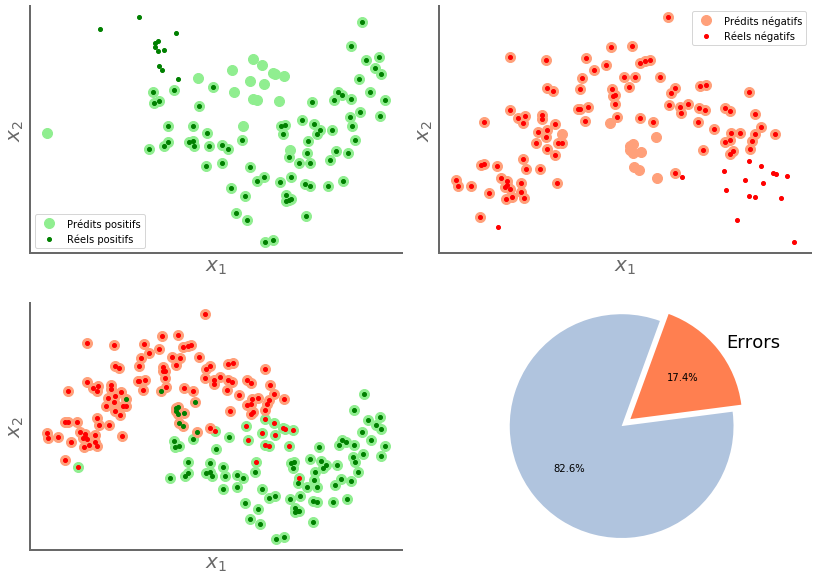

In [10]:
def show_results(y_proba_val, filename):
    y_pred = (y_proba_val >= 0.5)

    precision = metrics.precision_score(y_test, y_pred)
    recall    = metrics.recall_score(y_test, y_pred)

    print("Precision = {:5.3f}    Recall = {:5.3f}".format(precision, recall))

    y_pred_1d = y_pred.reshape(-1) # Passage en 1D
    y_test_1d = y_test.reshape(-1)

    X_pred_positives = X_test[ y_pred_1d == True]   # items prédits    positifs
    X_real_positives = X_test[ y_test_1d == 1 ]     # items réellement positifs
    X_pred_negatives = X_test[ y_pred_1d == False]  # items prédits    négatifs
    X_real_negatives = X_test[ y_test_1d == 0 ]     # items réellement négatifs

    fig, axs = plt.subplots(2, 2)
    fig.subplots_adjust(wspace=.1,hspace=0.2)
    fig.set_size_inches(14,10)
    print("Prédictions et erreurs")
    
    axs[0,0].plot(X_pred_positives[:,1], X_pred_positives[:,2], 'o',color='lightgreen', markersize=10, label="Prédits positifs")
    axs[0,0].plot(X_real_positives[:,1], X_real_positives[:,2], 'o',color='green',      markersize=4,  label="Réels positifs")
    axs[0,0].legend()
    axs[0,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[0,0].set_xlabel('$x_1$')
    axs[0,0].set_ylabel('$x_2$')


    axs[0,1].plot(X_pred_negatives[:,1], X_pred_negatives[:,2], 'o',color='lightsalmon', markersize=10, label="Prédits négatifs")
    axs[0,1].plot(X_real_negatives[:,1], X_real_negatives[:,2], 'o',color='red',        markersize=4,  label="Réels négatifs")
    axs[0,1].legend()
    axs[0,1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[0,1].set_xlabel('$x_1$')
    axs[0,1].set_ylabel('$x_2$')
    
    axs[1,0].plot(X_pred_positives[:,1], X_pred_positives[:,2], 'o',color='lightgreen', markersize=10, label="Prédits positifs")
    axs[1,0].plot(X_pred_negatives[:,1], X_pred_negatives[:,2], 'o',color='lightsalmon', markersize=10, label="Prédits négatifs")
    axs[1,0].plot(X_real_positives[:,1], X_real_positives[:,2], 'o',color='green',      markersize=4,  label="Réels positifs")
    axs[1,0].plot(X_real_negatives[:,1], X_real_negatives[:,2], 'o',color='red',        markersize=4,  label="Réels négatifs")
    axs[1,0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[1,0].set_xlabel('$x_1$')
    axs[1,0].set_ylabel('$x_2$')

    axs[1,1].pie([precision,1-precision], explode=[0,0.1], labels=["","Errors"], 
                 autopct='%1.1f%%', shadow=False, startangle=70, colors=["lightsteelblue","coral"])
    axs[1,1].axis('equal')

    plt.show()

show_results(y_proba_val, 'LogisticReg-d')


## Step 4 - Bending the space to a model #2 ;-)

We're going to increase the characteristics of our observations, with : ${x_1}^2$, ${x_2}^2$, ${x_1}^3$ et ${x_2}^3$  

$
X=
\begin{bmatrix}1 & x_{11} & x_{12} \\
\vdots & \dots\\
1 & x_{m1} & x_{m2}  \end{bmatrix}
\text{et }
X_{ng}=\begin{bmatrix}1 & x_{11} & x_{12} & x_{11}^2 & x_{12}^2& x_{11}^3 & x_{12}^3 \\
\vdots & & & \dots \\
1 & x_{m1} & x_{m2} & x_{m1}^2 & x_{m2}^2& x_{m1}^3 & x_{m2}^3 \end{bmatrix}
$

Note : `sklearn.preprocessing.PolynomialFeatures` can do that for us, but we'll do it ourselves:
### 4.1 - Extend data

In [15]:
X_train_enhanced = np.c_[X_train,
                         X_train[:, 1] ** 2,
                         X_train[:, 2] ** 2,
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        X_test[:, 1] ** 2,
                        X_test[:, 2] ** 2,
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]


### 4.2 - A more readable version of our model. Yes.
With logging for tensorboard and model checkpoints.

In [16]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):

    n_inputs_including_bias = int(X.get_shape()[1])
    
    with tf.name_scope("logistic_regression"):
        
        # ----- Construction du modèle
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            # X.theta
            logits = tf.matmul(X, theta, name="logits")
            # Probabilité
            y_proba = tf.sigmoid(logits)
            
        with tf.name_scope("train"):
            # Perte logistique
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            # Descente de gradient
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate2)
            training_op = optimizer.minimize(loss)
            # Trace
            loss_summary = tf.summary.scalar('log_loss', loss)
            
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
            
        with tf.name_scope("save"):
            saver = tf.train.Saver(max_to_keep=4)
            
    return y_proba, loss, training_op, loss_summary, init, saver


### 4.3 - Build the model

In [17]:
tf.reset_default_graph()

log_dir = './run/logs'
chk_dir = './run/models'
os.makedirs(log_dir, mode=0o750, exist_ok=True)
os.makedirs(chk_dir, mode=0o750, exist_ok=True)

X = tf.placeholder(tf.float32, shape=(None, data_cols + 1 + 4), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

# Model construction
y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

# Enregistrement du modèle
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

### 4.4 - Train the model

In [18]:
n_batches = int(np.ceil(data_size / batch_size2))

epoch_file  = chk_dir + "/epoch.last"
model_file  = chk_dir + "/model-ckpt"
model_final = chk_dir + "/model-final"

with tf.Session() as sess:
    
    # ----- Point de départ ? Checkpoint ou 0
    #
    if os.path.isfile(epoch_file):
        # Si epoch_file existe : On récupère l'époque et on restaure le checkpoint correspondant
        with open(epoch_file, "r") as f:
            epoch = int(f.read())
        saver.restore(sess, '{}-{}'.format(model_file,epoch))
        start_epoch=epoch+1
        print("Reprise de l'apprentissage à l'époque : ", start_epoch)
        print("Restauration du checkpoint            : ", chk_dir,'-',epoch)
    else:
        # epoch_file introuvable : On commence à 0
        start_epoch = 0
        sess.run(init)

    # ----- Ok, on y va...
    #
    for epoch in range(start_epoch, n_epochs2 + 1):
        
        for batch_index in range(n_batches):
            # Recupération du lot
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            # Apprentissage
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        # Calcul de la perte logistique et du log (en une seule fois)
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        # Enregistrement des logs
        file_writer.add_summary(summary_str, epoch)
        
        if epoch % 500 == 0:
            print('Epoch: {:6d}  Loss: {:8.4f}    checkpoint: {}-{}'.format(epoch,loss_val,model_file,epoch))
            # Sauvegarde d'un checkpoint
            saver.save(sess, model_file, global_step=epoch)
            # Sauvearde de l'epoch
            with open(epoch_file, "w") as f:
                f.write(str(epoch))

    # Sauvegarde du modèle final
    saver.save(sess, model_final)
    # Calcul des probabilités de l'échantillon test
    y_proba_val2 = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    # Supression de l'epoch_file
    os.remove(epoch_file)

Epoch:      0  Loss:   0.5859    checkpoint: ./run/models/model-ckpt-0
Epoch:    500  Loss:   0.1579    checkpoint: ./run/models/model-ckpt-500
Epoch:   1000  Loss:   0.1297    checkpoint: ./run/models/model-ckpt-1000
Epoch:   1500  Loss:   0.1174    checkpoint: ./run/models/model-ckpt-1500
Epoch:   2000  Loss:   0.1106    checkpoint: ./run/models/model-ckpt-2000
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch:   2500  Loss:   0.1065    checkpoint: ./run/models/model-ckpt-2500
Epoch:   3000  Loss:   0.1039    checkpoint: ./run/models/model-ckpt-3000
Epoch:   3500  Loss:   0.1023    checkpoint: ./run/models/model-ckpt-3500
Epoch:   4000  Loss:   0.1010    checkpoint: ./run/models/model-ckpt-4000
Epoch:   4500  Loss:   0.1003    checkpoint: ./run/models/model-ckpt-4500
Epoch:   5000  Loss:   0.1000    checkpoint: ./run/models/model-ckpt-5000
Epoch:   5500  Loss:   0.0995    checkpoint: ./run/models/model-ckpt-5500
Epoch:   6000  Loss:   0.0992   

### 4.5 - Evaluation

Precision = 0.955    Recall = 0.966
Prédictions et erreurs


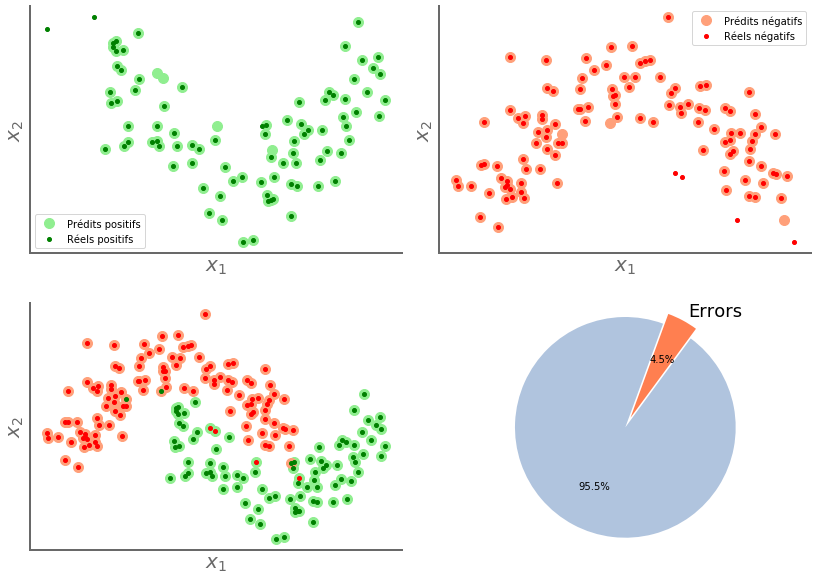

In [19]:
show_results(y_proba_val2, 'LogisticReg-e')

---
![](../fidle/img/00-Fidle-logo-01_s.png)